In [1]:
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import PorterStemmer
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
df = pd.read_csv('Sentiment_analysis_dataset.csv')
df = df.dropna(subset=['Statement', 'Status'])
df = df.drop(df[df.duplicated()][df[df.duplicated()]['Status'].isin(['Normal', 'Depression'])].index)

def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text
    
df['augmented_statement'] = df.apply(lambda row: augment_text(row['Statement'])
                                     if row['Status'] in ['Anxiety', 'Stress','Bipolar','Personality disorder'] else None, axis=1)
translated_rows = df[df['augmented_statement'].notna()]
translated_rows['Statement'] = translated_rows['augmented_statement']

df = pd.concat([df, translated_rows[['Statement', 'Status']]])

df = df.drop(columns=['augmented_statement'])

# Preprocess the text
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

stop_words = set(stopwords.words('english'))

def remove_stopwords_and_stem(text):
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Statement'] = df['Statement'].apply(lambda x: preprocess_text(x))
df['Statement'] = df['Statement'].apply(lambda x: remove_stopwords_and_stem(x))

# Encode labels
label_encoder = LabelEncoder()
df['Status'] = label_encoder.fit_transform(df['Status'])

X = df['Statement']
y = df['Status']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X_train_tfidf = vectorizer.fit_transform(X_train).toarray()

X_test_tfidf = vectorizer.transform(X_test)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_tfidf_smote, y_tfidf_smote = smote.fit_resample(X_train_tfidf, y_train)



C:\Users\User\AppData\Local\Temp\ipykernel_14536\2005120455.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  translated_rows['Statement'] = translated_rows['augmented_statement']


Testing Accuracy: 0.8161142857142857
Accuracy for training set: 0.9987951234205812
Model performance for Training set
- Root Mean Squared Error: 0.0941
- Mean Absolute Error: 0.0030
- R2 Score: 0.9978
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.4404
- Mean Absolute Error: 0.5760
- R2 Score: 0.4234
Classification Report
                      precision    recall  f1-score   support

             Anxiety       0.90      0.95      0.93      1077
             Bipolar       0.92      0.95      0.93       776
          Depression       0.73      0.67      0.70      2127
              Normal       0.87      0.93      0.90      2253
Personality disorder       0.98      0.93      0.95       302
              Stress       0.91      0.88      0.90       724
            Suicidal       0.65      0.62      0.64      1491

            accuracy                           0.82      8750
           macro avg       0.85      0.85      0.85      8750
      

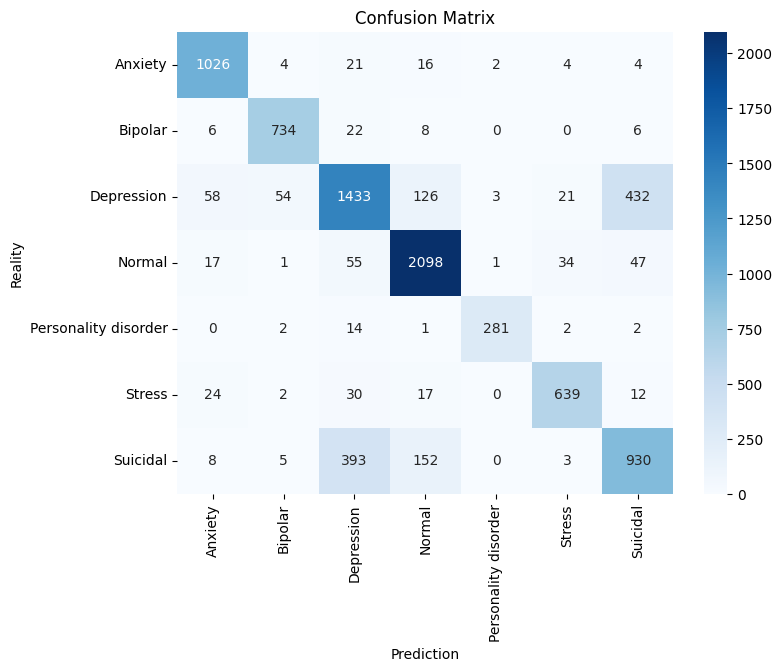

In [30]:
# Training model

randomForestModel = RandomForestClassifier(class_weight='balanced',n_estimators=100, random_state=42)

randomForestModel.fit(X_tfidf_smote, y_tfidf_smote)

# Predict
y_pred = randomForestModel.predict(X_test_tfidf)
# Make predictions
y_train_pred = randomForestModel.predict(X_tfidf_smote)

accuracy_test = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", accuracy_test)

accuracy_train = accuracy_score(y_tfidf_smote, y_train_pred)
print("Accuracy for training set:", accuracy_train)

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# Evaluate Train and Test dataset
model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_tfidf_smote, y_train_pred)

model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_pred)

print('Model performance for Training set')
print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
print("- R2 Score: {:.4f}".format(model_train_r2))

print('----------------------------------')

print('Model performance for Test set')
print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
print("- R2 Score: {:.4f}".format(model_test_r2))

print("Classification Report")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.show()

In [33]:
# Make prediction
def predict_mental_health_status(text):
    # Vectorize the input text
    text_vec = vectorizer.transform([text])
    
    # Make the prediction
    prediction = randomForestModel.predict(text_vec)
    
    # Convert the numerical prediction to the original category
    status = label_encoder.inverse_transform(prediction)
    
    return status[0]

text_1 = "This is really getting out of control I feel exhausted from the constant voices in my head and my heart racing during social situations. I feel like everything I do, could have been done better, and that I am inadequate. My avoidance is getting worse to the point where I am unable to do anything at all. As a medical student, I chose to study this major without truly understanding the challenges that would come with it. Now, during my clinical rotations, every encounter with each patient feels like a nightmare. I constantly feel judged, and I fear harsh criticism is always one step away from being directed at me. This constant mental battle leaves me with no room to use the knowledge that I have worked so hard to achieve."
result = predict_mental_health_status(text_1)
print(f"The predicted mental health status for the given text is: {result}")

text_2 = "I am feeling great and excited about the future."
result = predict_mental_health_status(text_2)
print(f"The predicted mental health status for the given text is: {result}")

text_3 = "I am feeling very anxious and stressed about work."
result = predict_mental_health_status(text_3)
print(f"The predicted mental health status for the given text is: {result}")

text_4 = "I don't see a reason to continue living, I just wanna die."
result = predict_mental_health_status(text_4)
print(f"The predicted mental health status for the given text is: {result}")

text_5 = "I act impulsively and regret it later."
result = predict_mental_health_status(text_5)
print(f"The predicted mental health status for the given text is: {result}")

text_6 = "The problem is, the mistakes I’ve made are the kind I can’t fix because I won’t be on shift to address them. I’m not sure what to say to be helpful or to ease the tension. I honestly feel like all my coworkers hate me, just like everyone else has. Ive already had three panic attacks at work."
result = predict_mental_health_status(text_6)
print(f"The predicted mental health status for the given text is: {result}")

text_7 = "I’m feeling completely overwhelmed right now. The constant voices in my head and my racing heart in social situations are exhausting. It feels like everything I do could have been done better, and that I’m just not good enough. My avoidance is worsening to the point where I can hardly do anything at all. As a medical student, I chose this path without truly grasping the challenges it would bring. Now, during my clinical rotations, every interaction with a patient feels like a nightmare. I constantly feel judged, and I’m always afraid that harsh criticism is just around the corner. This ongoing mental struggle leaves me no space to fully apply the knowledge I’ve worked so hard to gain."
result = predict_mental_health_status(text_7)
print(f"The predicted mental health status for the given text is: {result}")

text_8 = "i do not want to live this life, i just want to lay down without thinking about this life"
result = predict_mental_health_status(text_8)
print(f"The predicted mental health status for the given text is: {result}")

text_9 = "I really hate thinking about positive things and cant implement my ideas in real life"
result = predict_mental_health_status(text_9)
print(f"The predicted mental health status for the given text is: {result}")

text_10 = "One moment, I feel on top of the world, full of energy and ideas, and the next, I'm completely drained and struggling to get out of bed."
result = predict_mental_health_status(text_10)
print(f"The predicted mental health status for the given text is: {result}")


The predicted mental health status for the given text is: Depression
The predicted mental health status for the given text is: Normal
The predicted mental health status for the given text is: Anxiety
The predicted mental health status for the given text is: Normal
The predicted mental health status for the given text is: Normal
The predicted mental health status for the given text is: Depression
The predicted mental health status for the given text is: Depression
The predicted mental health status for the given text is: Suicidal
The predicted mental health status for the given text is: Normal
The predicted mental health status for the given text is: Normal


C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing Accuracy: 0.7312
Accuracy for training set: 0.8614709006452431
Model performance for Training set
- Root Mean Squared Error: 1.1493
- Mean Absolute Error: 0.3926
- R2 Score: 0.6697
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.6728
- Mean Absolute Error: 0.8014
- R2 Score: 0.2223
Classification Report
                      precision    recall  f1-score   support

             Anxiety       0.82      0.87      0.85      1077
             Bipolar       0.85      0.85      0.85       776
          Depression       0.69      0.62      0.65      2127
              Normal       0.88      0.76      0.82      2253
Personality disorder       0.64      0.90      0.75       302
              Stress       0.59      0.77      0.67       724
            Suicidal       0.59      0.63      0.61      1491

            accuracy                           0.73      8750
           macro avg       0.72      0.77      0.74      8750
        weighted a

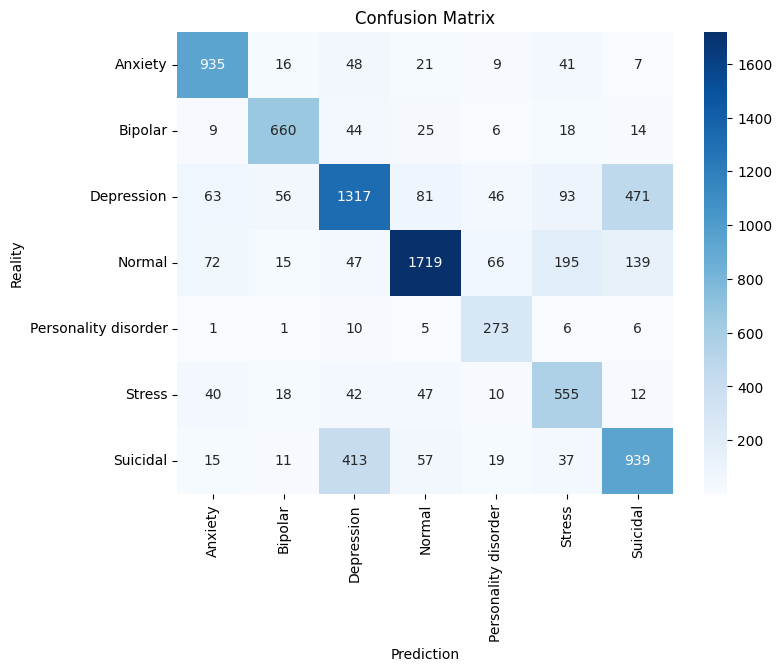

In [32]:
# Training model
from sklearn.linear_model import LogisticRegression

logisticRegressorModel = LogisticRegression(C=100)

logisticRegressorModel.fit(X_tfidf_smote, y_tfidf_smote)

# Predict
y_pred = logisticRegressorModel.predict(X_test_tfidf)
 # Make predictions
y_train_pred = logisticRegressorModel.predict(X_tfidf_smote)

accuracy_test = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", accuracy_test)

accuracy_train = accuracy_score(y_tfidf_smote, y_train_pred)
print("Accuracy for training set:", accuracy_train)

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# Evaluate Train and Test dataset
model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_tfidf_smote, y_train_pred)

model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_pred)

print('Model performance for Training set')
print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
print("- R2 Score: {:.4f}".format(model_train_r2))

print('----------------------------------')

print('Model performance for Test set')
print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
print("- R2 Score: {:.4f}".format(model_test_r2))

print("Classification Report")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.show()

Testing Accuracy: 0.04445356312405964
Accuracy for training set: 0.9120757169808329
Model performance for Training set
- Root Mean Squared Error: 0.9654
- Mean Absolute Error: 0.2631
- R2 Score: 0.7670
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 2.6240
- Mean Absolute Error: 2.2227
- R2 Score: -1.1463
Classification Report
                      precision    recall  f1-score   support

             Anxiety       0.19      0.06      0.09       538
             Bipolar       0.04      0.62      0.08       388
          Depression       0.00      0.00      0.00      2127
              Normal       0.00      0.00      0.00      2253
Personality disorder       0.03      0.34      0.05       151
              Stress       0.29      0.01      0.01       362
            Suicidal       0.00      0.00      0.00      1492

            accuracy                           0.04      7311
           macro avg       0.08      0.15      0.03      7311
    

C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\User\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

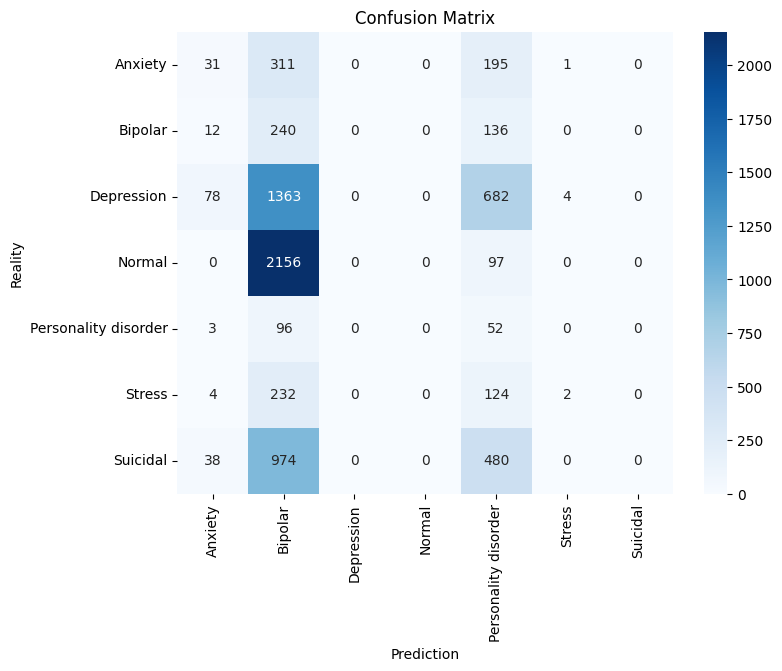

In [9]:
from xgboost import XGBClassifier

xgbModel = XGBClassifier(n_estimators=100, random_state=42)
xgbModel.fit(X_tfidf_smote,y_tfidf_smote)

y_train_pred = xgbModel.predict(X_tfidf_smote)
y_pred = xgbModel.predict(X_test_tfidf)

accuracy_test = accuracy_score(y_test, y_pred)
print("Testing Accuracy:", accuracy_test)

accuracy_train = accuracy_score(y_tfidf_smote, y_train_pred)
print("Accuracy for training set:", accuracy_train)

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# Evaluate Train and Test dataset
model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_tfidf_smote, y_train_pred)

model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_pred)

print('Model performance for Training set')
print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
print("- R2 Score: {:.4f}".format(model_train_r2))

print('----------------------------------')

print('Model performance for Test set')
print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
print("- R2 Score: {:.4f}".format(model_test_r2))

print("Classification Report")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.show()



In [15]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, GlobalMaxPooling1D, Embedding, Dropout

tokenizer = Tokenizer(num_words=10000)

tokenizer.fit_on_texts(X_train_concat)

X_train_sequences = tokenizer.texts_to_sequences(X_train_concat)  # Convert text to sequences of integers
X_test_sequences = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_sequences, padding='post', maxlen=200)
X_test_padded = pad_sequences(X_test_sequences, padding='post', maxlen=200)

X_smote, y_smote = smote.fit_resample(X_train_padded, y_train_concat)

In [25]:
# Build the CNN model
from keras.regularizers import l2
from keras.layers import LSTM, Bidirectional


cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=10000, output_dim=128))

# Add multiple convolutional layers with different kernel sizes
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
cnn_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))

# Optional: Add Bidirectional LSTM layer (to capture sequential context)
cnn_model.add(Bidirectional(LSTM(128, return_sequences=False)))

# Fully connected layer
cnn_model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

# Dropout for regularization
cnn_model.add(Dropout(0.5))

# Output layer for multi-class classification (assuming 7 classes here)
cnn_model.add(Dense(7, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(X_smote, y_smote, epochs=5, validation_split=0.2, batch_size=32)


Epoch 1/5
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 204s 128ms/step - accuracy: 0.4003 - loss: 1.7412 - val_accuracy: 0.1304 - val_loss: 2.9032
Epoch 2/5
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 203s 128ms/step - accuracy: 0.6287 - loss: 1.0002 - val_accuracy: 0.2162 - val_loss: 3.0000
Epoch 3/5
1577/1577 ━━━━━━━━━━━━━━━━━━━━ 197s 125ms/step - accuracy: 0.6946 - loss: 0.8352 - val_accuracy: 0.2785 - val_loss: 3.2352
Epoch 4/5
1279/1577 ━━━━━━━━━━━━━━━━━━━━ 35s 119ms/step - accuracy: 0.7289 - loss: 0.7377

KeyboardInterrupt: 